In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Data

In [2]:
data, labels = sk.datasets.load_iris()['data'], sk.datasets.load_iris()['target']

data = torch.tensor(data, dtype = torch.float)
labels = torch.tensor(labels, dtype = torch.long)

# Preprocessing

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = X_test.shape[0])

# Model Arch

In [4]:
class ModelArch(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(4, 128)
    self.hidden = nn.Linear(128, 128)
    self.output = nn.Linear(128, 3)

  def forward(self, x):
    x = self.input(x)
    x = F.relu(x)

    x = self.hidden(x)
    x = F.relu(x)

    x = self.output(x)

    return x

# Model Setup

In [9]:
def ModelSetup(L2_lambda, optimizer):
  ann = ModelArch()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optimizer(ann.parameters(), lr = 0.001, weight_decay = L2_lambda)

  return ann, loss_fn, optimizer

# Model Train

In [10]:
def train(L2_lambda, epochs, optimizer):
  ann, loss_fn, optimizer = ModelSetup(L2_lambda, optimizer)

  train_losses = torch.zeros(epochs)
  test_losses = torch.zeros(epochs)

  train_accs = torch.zeros(epochs)
  test_accs = torch.zeros(epochs)

  for epoch in range(epochs):
    ann.train()

    batch_losses = torch.zeros(len(train_dataloader))
    batch_accs = torch.zeros(len(train_dataloader))

    for batch, (X_train, y_train) in enumerate(train_dataloader):
      batch_y_hat = ann(X_train)

      batch_loss = loss_fn(batch_y_hat, y_train)
      batch_losses[batch] = batch_loss

      batch_acc = 100 * torch.mean(
          (torch.argmax(batch_y_hat, axis = 1) == y_train).float()
      )
      batch_accs[batch] = batch_acc

      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    train_losses[epoch] = torch.mean(batch_losses)
    train_accs[epoch] = torch.mean(batch_accs)

    ann.eval()

    X_test, y_test = next(iter(test_dataloader))
    test_y_hat = ann(X_test)

    test_loss = loss_fn(test_y_hat, y_test)
    test_losses[epoch] = test_loss

    test_acc = 100 * torch.mean(
          (torch.argmax(test_y_hat, axis = 1) == y_test).float()
      )
    test_accs[epoch] = test_acc

    if epoch % 10 == 0:
      print(f'Ep: {epoch} | Train -> Loss: {batch_loss:2f}, Acc: {batch_acc:2f} | Test -> Loss: {test_loss:2f}, Acc: {test_acc:2f}')

  return train_losses, train_accs, test_losses, test_accs

In [11]:
train_losses, train_accs, test_losses, test_accs = train(0.2, 100, torch.optim.SGD)

Ep: 0 | Train -> Loss: 1.089458, Acc: 8.333334 | Test -> Loss: 1.089633, Acc: 16.666668
Ep: 10 | Train -> Loss: 1.037260, Acc: 29.166666 | Test -> Loss: 1.037285, Acc: 30.000002
Ep: 20 | Train -> Loss: 0.997823, Acc: 33.333336 | Test -> Loss: 1.006928, Acc: 30.000002
Ep: 30 | Train -> Loss: 0.972337, Acc: 50.000000 | Test -> Loss: 0.983065, Acc: 43.333332
Ep: 40 | Train -> Loss: 0.964098, Acc: 66.666672 | Test -> Loss: 0.958536, Acc: 60.000004
Ep: 50 | Train -> Loss: 0.903157, Acc: 66.666672 | Test -> Loss: 0.936985, Acc: 60.000004
Ep: 60 | Train -> Loss: 0.837045, Acc: 83.333328 | Test -> Loss: 0.917088, Acc: 60.000004
Ep: 70 | Train -> Loss: 0.869131, Acc: 66.666672 | Test -> Loss: 0.895298, Acc: 60.000004
Ep: 80 | Train -> Loss: 0.826924, Acc: 70.833328 | Test -> Loss: 0.875970, Acc: 60.000004
Ep: 90 | Train -> Loss: 0.814089, Acc: 75.000000 | Test -> Loss: 0.855850, Acc: 60.000004


# Experiment

In [8]:
def smooth(x, k = 5):
  return torch.tensor(np.convolve(x, np.ones(k)/k, mode = 'same'), dtype= torch.float)

In [68]:
l2_lambdas = np.linspace(0, .1, 10)
optimizers = [torch.optim.SGD, torch.optim.Adam, torch.optim.RMSprop]
epochs = 50
test_accs_results = torch.zeros(len(optimizers), len(l2_lambdas))
adam_l2_results = torch.zeros(epochs, len(l2_lambdas))

for optim_idx, optim in enumerate(optimizers):
  for l2_idx, l2 in enumerate(l2_lambdas):

    print(f'\n\nPROCESSING: L2 Lambda: {l2_lambdas[l2_idx]} | Optimizer: {optimizers[optim_idx]}')
    train_losses, train_accs, test_losses, test_accs = train(l2, epochs, optim)

    test_accs_results[optim_idx, l2_idx] = torch.mean(test_accs[-10:])
    if optim_idx == 1:
      adam_l2_results[:, l2_idx] = test_accs



PROCESSING: L2 Lambda: 0.0 | Optimizer: <class 'torch.optim.sgd.SGD'>
Ep: 0 | Train -> Loss: 1.238965, Acc: 29.166666 | Test -> Loss: 1.138110, Acc: 30.000002
Ep: 10 | Train -> Loss: 1.002937, Acc: 79.166672 | Test -> Loss: 1.026983, Acc: 60.000004
Ep: 20 | Train -> Loss: 0.978329, Acc: 58.333332 | Test -> Loss: 0.991958, Acc: 60.000004
Ep: 30 | Train -> Loss: 0.937498, Acc: 66.666672 | Test -> Loss: 0.965872, Acc: 60.000004
Ep: 40 | Train -> Loss: 0.898791, Acc: 70.833328 | Test -> Loss: 0.939298, Acc: 60.000004


PROCESSING: L2 Lambda: 0.011111111111111112 | Optimizer: <class 'torch.optim.sgd.SGD'>
Ep: 0 | Train -> Loss: 1.378839, Acc: 12.500000 | Test -> Loss: 1.262326, Acc: 30.000002
Ep: 10 | Train -> Loss: 1.063971, Acc: 45.833336 | Test -> Loss: 1.083994, Acc: 30.000002
Ep: 20 | Train -> Loss: 1.038439, Acc: 33.333336 | Test -> Loss: 1.032178, Acc: 30.000002
Ep: 30 | Train -> Loss: 0.968804, Acc: 41.666664 | Test -> Loss: 0.990529, Acc: 30.000002
Ep: 40 | Train -> Loss: 0.92767

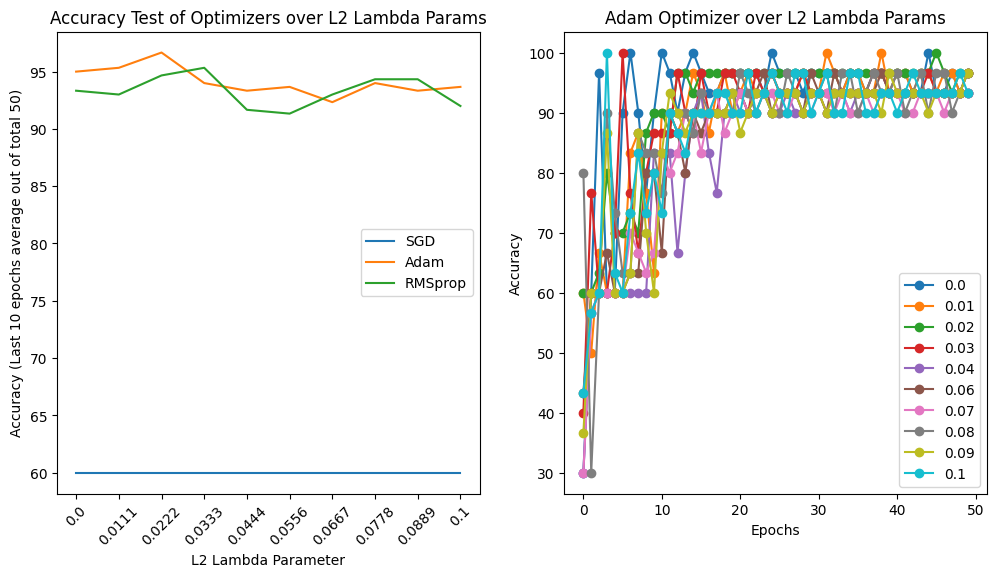

In [85]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

ax[0].plot(test_accs_results.detach()[0], label = 'SGD')
ax[0].plot(test_accs_results.detach()[1], label = 'Adam')
ax[0].plot(test_accs_results.detach()[2], label = 'RMSprop')
ax[0].set_ylabel(f'Accuracy (Last 10 epochs average out of total {epochs})')
ax[0].legend(['SGD', 'Adam', 'RMSprop'])
ax[0].set_xlabel('L2 Lambda Parameter')
ax[0].set_xticks(range(len(l2_lambdas)), [str(np.round(l2,4)) for l2 in l2_lambdas], rotation=45)
ax[0].set_title('Accuracy Test of Optimizers over L2 Lambda Params')

ax[1].plot(adam_l2_results, '-o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Adam Optimizer over L2 Lambda Params')
ax[1].legend([np.round(l2,2) for l2 in l2_lambdas])

plt.show()